In [27]:
from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import numpy as np

%matplotlib inline

In [2]:
from trackml.dataset import load_event
hits, cells, particles, truth = load_event('C:/Users/acer/Desktop/Education/math/MATH 189/Final Project/MATH189_FINAL_PROJ-master/MATH189_FINAL_PROJ-master/data/train_100_events/event000001000')

In [3]:
cells.head()

,hit_id,ch0,ch1,value
0,1,209,617,0.013832
1,1,210,617,0.079887
2,1,209,618,0.211723
3,2,68,446,0.334087
4,3,58,954,0.034005


In [4]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503668346847232,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1,8
1,4503737066323968,-0.009288,0.009861,-0.077879,-0.948125,0.470892,2.010060,1,11
2,4503805785800704,-0.009288,0.009861,-0.077879,-0.886484,0.105749,0.683881,-1,0
3,4503874505277440,-0.009288,0.009861,-0.077879,0.257539,-0.676718,0.991616,1,12
4,4503943224754176,-0.009288,0.009861,-0.077879,16.439400,-15.548900,-39.824902,1,3


In [5]:
truth.head()

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000
1,2,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
2,3,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000
3,4,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
4,5,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009


(array([2375.,  596.,  656.,  667.,  926., 2595., 3026., 1211.,  196.,
          15.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

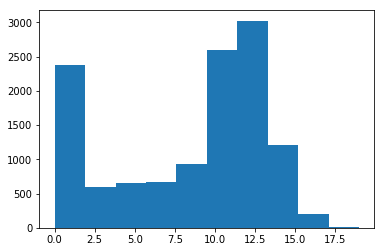

In [6]:
plt.hist(particles.nhits)

In [7]:
pos_part = particles[particles.q == 1]
neg_part = particles[particles.q == -1]

(array([1451.,  364.,  384.,  396.,  510., 1296., 1608.,  647.,  120.,
          13.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

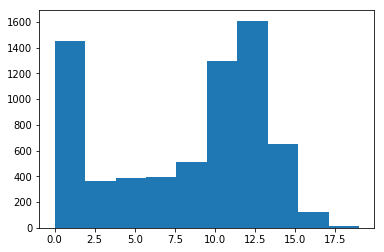

In [8]:
plt.hist(pos_part.nhits)

(array([ 924.,  232.,  272.,  271.,  172.,  763., 1605.,  980.,  242.,
          13.]),
 array([ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. ]),
 <a list of 10 Patch objects>)

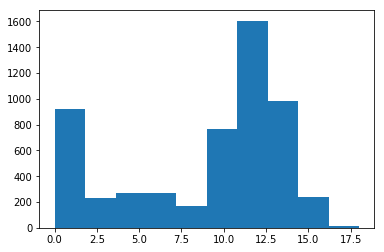

In [9]:
plt.hist(neg_part.nhits)

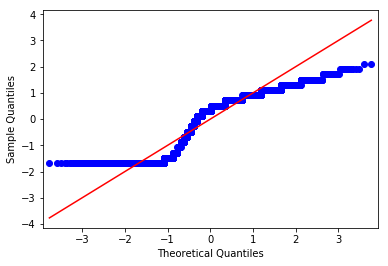

In [13]:
fig = qqplot(particles.nhits, fit = True, line='s')


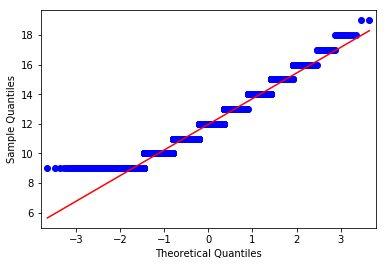

In [26]:
trunc_nhits = particles[particles.nhits >8].nhits
fig = qqplot(trunc_nhits, line='s')

### Analysis

Wtf is going with the LHS of the QQ plot?

(array([ 656.,  355.,  687.,  551., 2595., 1679., 2176.,  382.,  196.,
          15.]),
 array([ 4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. , 17.5, 19. ]),
 <a list of 10 Patch objects>)

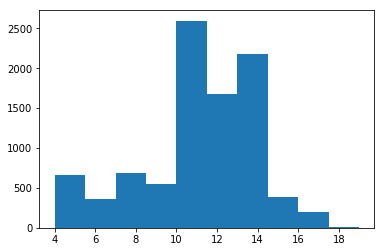

In [25]:
plt.hist(trunc_nhits)


# Adding Noise Because Discrete Data Looks Weird

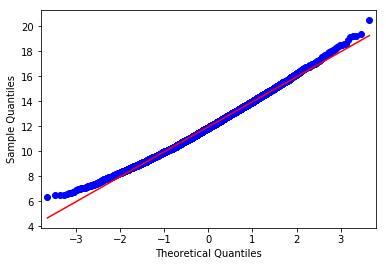

In [34]:

eps = np.random.normal(0,s, trunc_nhits.shape)
trunc_nhits_random = trunc_nhits + eps

fig = qqplot(trunc_nhits_random, line='s')

# Analysis

By adding noise, we see that normality is restored, so we can trust that QQ-plot is working

# Straight Shot Paths Through Analyzing Truth